# Graph Laplacians and low-dim embeddings

## 1. Preliminaries

Let's start from the simpler case of an unoriented unweighted graph $G$, with a set of vertices $V=\{e_1,\ldots, e_n\}$ and edges $E$; we associate to it the so called *adjacency matrix* $A$, a symmetric $n\times n$ matrix defined as follows  
$$A_{ij}=\left\{\begin{array}{cl}1&\textrm{ if }\{e_i,\ e_j\}\in E\\0&\textrm{ otherwise }\end{array}\right.$$
We also define the *degree matrix* which is a diagonal matrix $D$ such that $D_{ij}=0$ if $i\neq j$ and $D_{ii}$ is the *degree* of the vertex $e_i$ i.e. the number of edges that contain $e_i$:
$$d_{ii}=\deg(e_i)=\left\vert\{e_j\in V\ :\ \{e_i, e_j\}\in E\}\right\vert=\sum_{j=1}^n A_{ij}=\sum_{j=1}^nA_{ji}\;.$$

For us, in practice, a graph will be given as a pair *(number_of_vertices, list_of_edges)*; as an example, we define some functions that give the list of edges of some common graphs.

In [106]:
import numpy as np

#cyclic graph on n elements
def Cyclic(n):
    return (n, np.array([[j,(j+1)%n] for j in range(n)]))

#complete graph on n elements
def Kgrafo(n):
    ed=[]
    for j in range(n):
        for i in range(j+1,n):
            ed.append([i,j])
    return (n,np.array(ed))

#"toric" graph (standard square mesh on S^1xS^1) - n is the number of points on each S^1
def Toro(n):
    ed=[]
    for j in range(n**2):
        for i in range(j+1,n**2):
            if min(abs((contagrid(j,n)-contagrid(i,n))[0]),n-abs((contagrid(j,n)-contagrid(i,n))[0]))+min(abs((contagrid(j,n)-contagrid(i,n))[1]),n-abs((contagrid(j,n)-contagrid(i,n))[1]))==1:
                ed.append([j,i])
    return (n**2,np.array(ed))

#"cylindric" graph (standard square mesh on S^1x[0,1]) - n is the number of points on S^1 and on [0,1]
def Cilindro(n):
    ed=[]
    for j in range(n**2):
        for i in range(j+1,n**2):
            if min(abs((contagrid(j,n)-contagrid(i,n))[0]),n-abs((contagrid(j,n)-contagrid(i,n))[0]))+abs((contagrid(j,n)-contagrid(i,n))[1])==1:
                ed.append([j,i])
    return (n**2,np.array(ed))

#inverse of flatting for a 2d-array
def contagrid(j,n):
    x=j%n
    y=(j-x)//n
    return np.array([x,y])

#squared grid graph
def Griglia(l):
    ed=[]
    for j in range(l**2):
        for i in range(j+1,l**2):
            if abs((contagrid(j,l)-contagrid(i,l))[0])+abs((contagrid(j,l)-contagrid(i,l))[1])==1:  
                ed.append([j,i])
    return (l**2,np.array(ed))

In [107]:
m=5
(V,E)=Cyclic(m)
print('The cyclic graph on %d elements has, unsurprisingly %d vertices, numbered from 0 to %d'%(m,V,(V-1)))
print('and its edges are:')
for edge in E:
    print(edge)

The cyclic graph on 5 elements has, unsurprisingly 5 vertices, numbered from 0 to 4
and its edges are:
[0 1]
[1 2]
[2 3]
[3 4]
[4 0]


Next, we define a naive algorithm that computes the adjacency and the degree matrices for a graph given in the form *(number_of_vertices, list_of_edges)*.

We test in on the cyclic graph defined before.

In [108]:
#It takes the pair (V,E) as input and gives A,D as outputs.
def Matrici(GR):
    n=GR[0]
    Matr=np.zeros((n,n))
    for e in GR[1]:
        i=e[0]
        j=e[1]
        Matr[i][j]=1
        Matr[j][i]=1
    degrees=np.dot(Matr,np.ones((n)))
    return Matr, np.diag(degrees)

A,D=Matrici((V,E))
print('The adjacency matrix of the cyclic graph of order %d is'%V)
print(A)
print('\nThe degree matrix is')
print(D)

The adjacency matrix of the cyclic graph of order 5 is
[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]

The degree matrix is
[[2. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 2.]]


The **Laplacian matrix** of the graph is $L=D-A$; by its definition, $L$ has a kernel which contains at least the vector with all $1$'s, as every element on the diagonal is the opposite of the sum of all other elements on its row.

In [109]:
L=D-A
print('The Laplacian matrix of the cyclic graph of order %d is'%V)
print(L)
print('\nand, as anticipated, the rank of L is %d, which is less than its order %d'%(np.linalg.matrix_rank(L), V))


The Laplacian matrix of the cyclic graph of order 5 is
[[ 2. -1.  0.  0. -1.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [-1.  0.  0. -1.  2.]]

and, as anticipated, the rank of L is 4, which is less than its order 5


## 2 .First embedding problem
We would like to define a map $F:V\to\mathbb{R}^n$ in a way that minimizes the distance between connected vertices, without identifying them (obviously). Let us denote by $\{e_1,\ldots, e_m\}$ the elements of $V$ and by $x_1,\ldots, x_m$ the corresponding images in $\mathbb{R}^n$.

We want to minimize the sum of the squares of the distances between points that correspond to connected vertices; we call our quantity $\delta(F)$.  
We write an expression for it by defining $N_i=\{j\in \{1,\ldots, m\}\ :\ \{e_i,e_j\}\in E\}$, so
$$\delta(F)=\frac{1}{2}\sum_{i=1}^m\sum_{j\in N_i}\|x_i-x_j\|^2\;.$$

Therefore
$$\delta(F)=\frac{1}{2}\sum_{i=1}^m\sum_{j\in N_i}x_i^t(x_i-x_j)-x_j^t(x_i-x_j)=\sum_{i=1}^mx_i^t\sum_{j\in N_i}(x_i-x_j)=\sum_{i=1}^mx_i^t\left(d_ix_i-\sum_{j\in N_i}x_j\right)\;,$$
where we put $d_i=\deg(e_i)=D_{ii}$. Now, separating the coordinates, we write
$$\delta(F)=\sum_{h=1}^n\sum_{i=1}^nx_i^h\left(D_{ii}x_i^h-\sum_{j\in N_i}x_j^h\right)=\sum_{h=1}^n\sum_{i,j=1}^mx_i^hL_{ij}x^h_j\;.$$

We proceed to study the quadratic form on $\mathbb{R}^m$ given by $q(y)=y^tLy$; to minimize it without having equal coordinates (which would imply that we collaps all the vertices of the graph to the same point), we need to diagonalize $L$ and take the eigenvectors relative to the smallest positive eigenvalues.

Suppose that $v_1,\ldots, v_{m-1}$ are the eigenvectors relative to the non-zero eigenvalues of $L$ (in the case $\mathrm{rk}L=m-1$, i.e. that of a connected graph), ordered in increasing value of their respective eigenvalues.

Using the first $n$ eigenvectors will give $n$ coordinates for each point, namely the first component of the first $n$ eigenvectors form the vector $x_1\in\mathbb{R}^n$ and so on.

We define a function that, given a graph $G$, returns the adjaciency and degree matrices, together with the list of eigenvalues of the Laplacian of $G$ and the list of corresponding eigenvectors.

In [110]:
def Spettro(grafo):
    A,D=Matrici(grafo)
    L=D-A
    eigval, bev=np.linalg.eigh(L)
    return A,D,eigval,bev

A,D,eigval,bev=Spettro((V,E))
print('For our cyclic graph, the eigenvalues of the Laplacian are')
for j in range(len(eigval)):
    with np.printoptions(precision=3, suppress=True):
        print('%.3f with eigevector  '%eigval[j]+str(bev[:,j]))


For our cyclic graph, the eigenvalues of the Laplacian are
-0.000 with eigevector  [0.447 0.447 0.447 0.447 0.447]
1.382 with eigevector  [ 0.253  0.63   0.137 -0.545 -0.473]
1.382 with eigevector  [-0.58   0.061  0.618  0.321 -0.419]
3.618 with eigevector  [-0.629  0.546 -0.253 -0.136  0.473]
3.618 with eigevector  [-0.062 -0.32   0.58  -0.618  0.42 ]


Rough visualization algorithms for 2d and 3d embedding are obtained as follows (they are not interesting as algorithms, but at least we can see what the results are in a more graphical way).

<IPython.core.display.Javascript object>


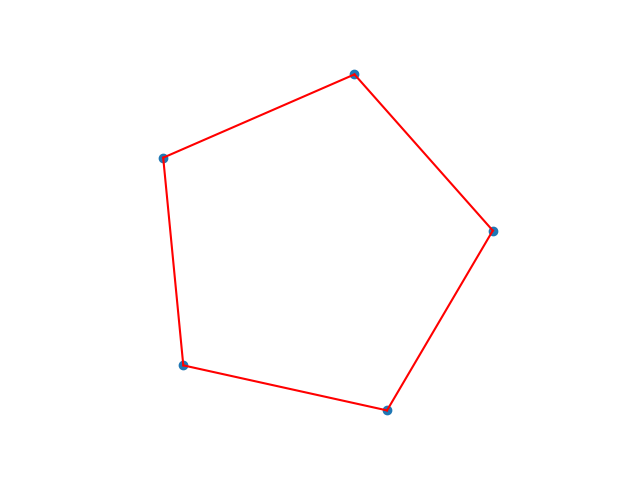

In [111]:
%matplotlib notebook

import matplotlib.pyplot as plt

#generates the 2d plot starting from coordinates and list of edges
def rappr2d(x,y,ed, nomi=False):
    f, ax=plt.subplots()
    ax.scatter(x,y)
    if nomi==True:
        for k in range(len(x)):
            ax.text(x[k], y[k], '  %d'%k,color='black')
    for arco in ed:
        ax.plot([x[arco[0]],x[arco[1]]],[y[arco[0]], y[arco[1]]], color='red')       
    return ax

#generates the 3d plot starting from coordinates and list of edges
def rappr3d(x,y,z,ed, nomi=False):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(x,y,z)
    if nomi==True:
        for k in range(len(x)):
            ax.text(x[k],y[k],z[k],'  %d'%k,color='black')
    for arco in ed:
        ax.plot([x[arco[0]],x[arco[1]]],[y[arco[0]],y[arco[1]]],[z[arco[0]],z[arco[1]]], color='red')
    return ax

#a container for the 2d representation, in order to discard the smallest eigevalues if they are smaller than a set precision
#(i.e. we allow for some error on the calculation of the 0 eigenvalue - not really useful here)
def emb2d(grafo,aval, bav, prec=1e-10, nomi=False):
    rk=np.argmax(aval>prec)-1
    return rappr2d(bav[:,rk+1], bav[:,rk+2],grafo[1], nomi)

#a container for the 2d representation, in order to discard the smallest eigevalues if they are smaller than a set precision
#(i.e. we allow for some error on the calculation of the 0 eigenvalue - not really useful here)
def emb3d(grafo,aval, bav,prec=1e-10, nomi=False):
    rk=np.argmax(aval>prec)-1
    return rappr3d(bav[:,rk+1], bav[:,rk+2], bav[:,rk+3],grafo[1], nomi)

plot_plane=emb2d((V,E), eigval, bev)
plot_plane.axis('off')
plot_plane.set_aspect('equal')
plt.show()


<IPython.core.display.Javascript object>


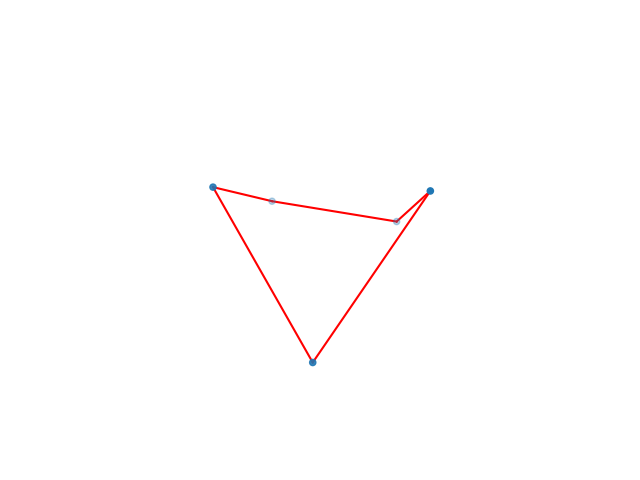

In [112]:
plot_space=emb3d((V,E), eigval, bev)
foo=plot_space.axis('off')

Just for fun, we will show what happens in the plane with some more graphs:
- the cyclic graph on 20 elements
- the complete graph on 12 elements
- the grid with side 10 (100 vertices)
- the torus with side 10 (100 vertices)
- the cylinder with side 10 (100 vertices)

In [113]:
Graphs=[Cyclic(20), Kgrafo(12), Griglia(10), Cilindro(10), Toro(10)]
DataG=[]
for G in Graphs:
    tmp=[G]
    S=Spettro(G)
    tmp+=[s for s in S]
    DataG.append(tmp)


<IPython.core.display.Javascript object>


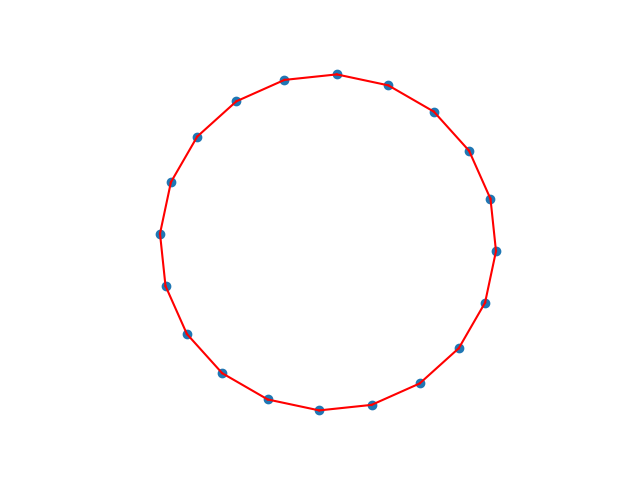

<IPython.core.display.Javascript object>


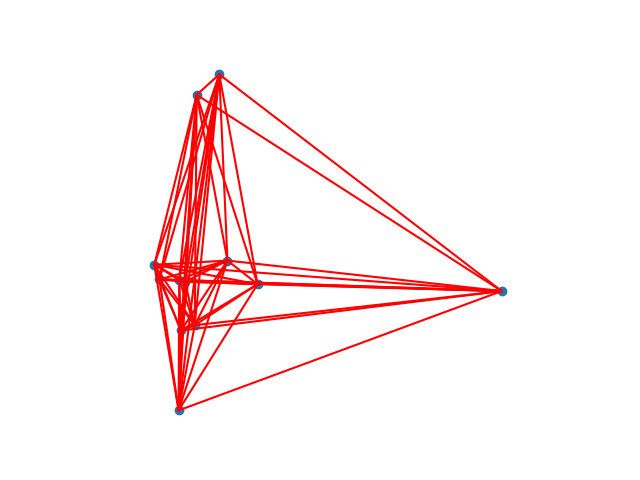

<IPython.core.display.Javascript object>


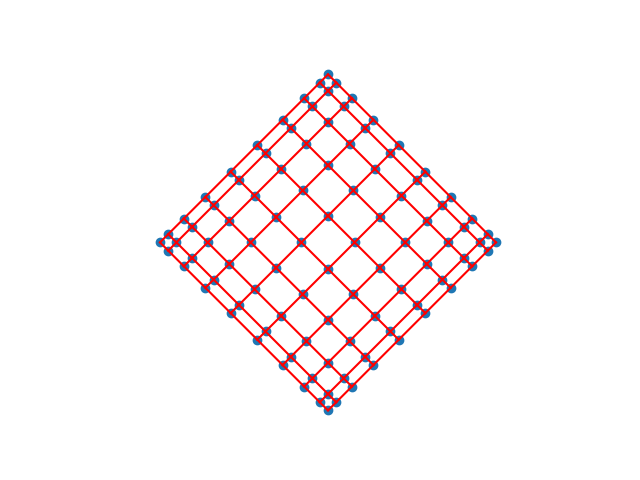

<IPython.core.display.Javascript object>


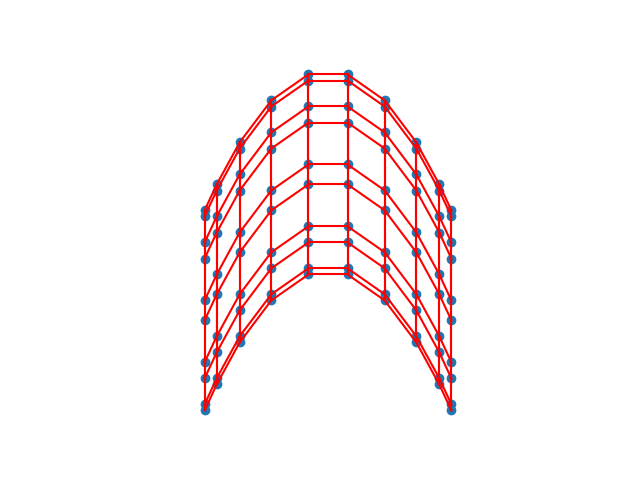

<IPython.core.display.Javascript object>


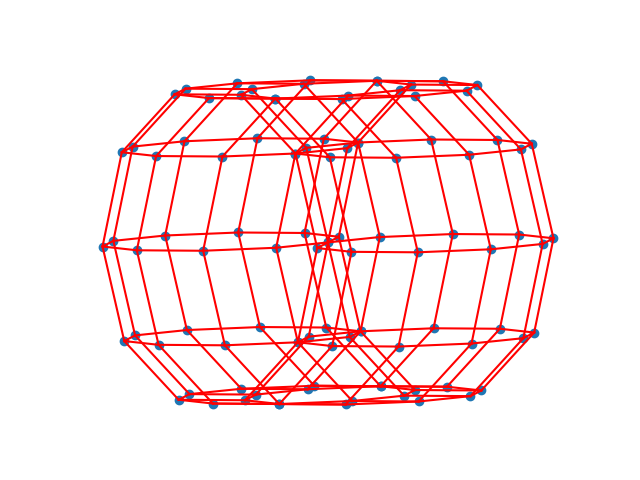

In [114]:
for D in DataG:
    plot_plane=emb2d(D[0], D[3], D[4])
    plot_plane.axis('off')
    plot_plane.set_aspect('equal')
    plt.show()

And now, in the space.

<IPython.core.display.Javascript object>


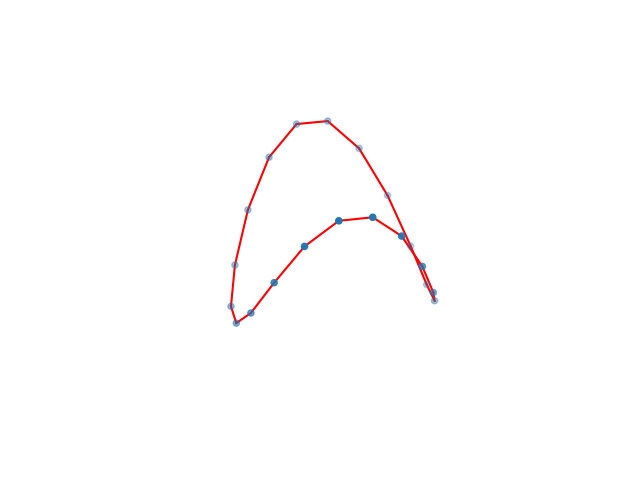

<IPython.core.display.Javascript object>


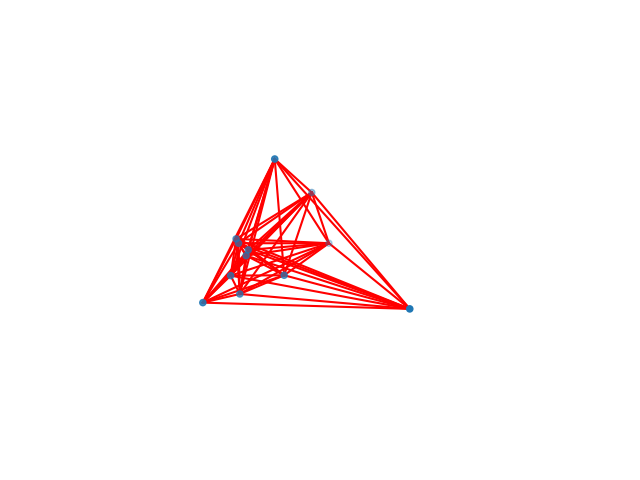

<IPython.core.display.Javascript object>


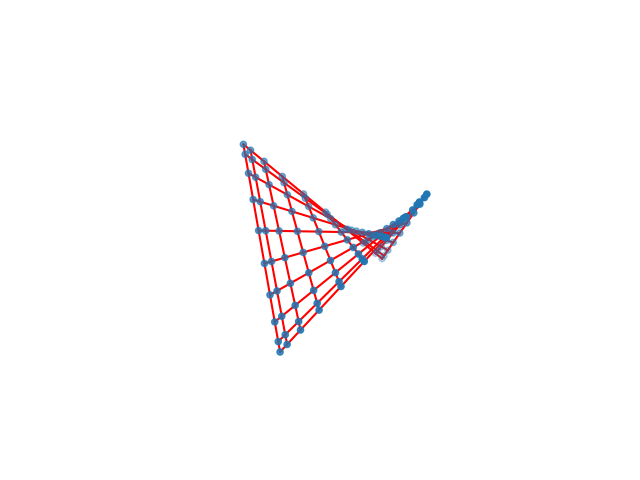

<IPython.core.display.Javascript object>


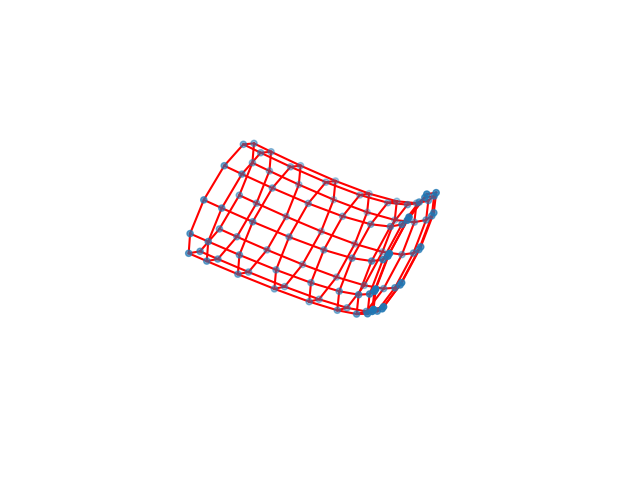

<IPython.core.display.Javascript object>


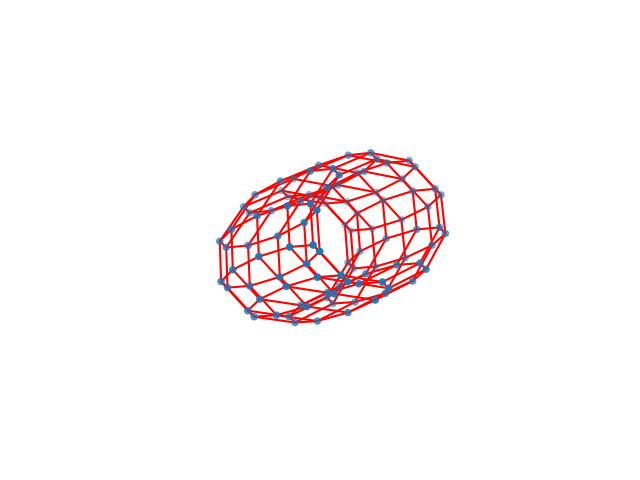

In [115]:
for D in DataG:
    plot_space=emb3d(D[0], D[3], D[4])
    plot_space.axis('off')
    plt.show()

## 3. The weighted case
In the weighted case, we assign a *weight* to each edge of the graph, which expresses the **strength** of the connection between the two vertices connected by that edge. In a way, two points that are not connected could be represented with an edge with zero weight. As an example, weights could be inverses of distances or $\exp(-\mathrm{dist}^2)$ or something like that, that goes to $0$ when two vertices should be separated.

In such case, the adjacency matrix is replaced by the weights matrix $W$ which simply has in position $(i,j)$ the weight $W_{ij}$ of the edge $\{e_i, e_j\}$.  
Accordingly, the degree matrix is defined with $D_{ii}=\sum_{j}W_{ij}$ and $D_{ij}=0$ if $i\neq j$.

The reasoning now proceeds in the same way: we want to minimize a function that looks like
$$\delta_w(F)=\sum_{i,j}W_{ij}\|x_i-x_j\|^2$$
because we want the edges with higher weights to be shorter, i.e. their endpoints to be closer, as an higher weight means a stronger connection. With the same computations, we end up with a quadratic form for each component, whose symmetric matrix is the **Laplacian** of the weighted graph, i.e. $L=D-W$.

We define the new function returning the matrices $W$, $D$ for weighted graphs; the other functions can be applied also here.

We run a few tests, just for fun.

In [116]:
#A weighted graph is (number_of_vertices, list_of_weighted_edges) were a weighted edge is [i,j,weight_ij]
#The following function works with both types of graph

def Matrici(GR):
    n=GR[0]
    Matr=np.zeros((n,n))
    if len(GR[1][0])==3:
        for e in GR[1]:
            i=int(e[0])
            j=int(e[1])
            Matr[i][j]=e[2]
            Matr[j][i]=e[2]
    else:
        for e in GR[1]:
            i=e[0]
            j=e[1]
            Matr[i][j]=1
            Matr[j][i]=1
    degrees=np.dot(Matr,np.ones((n)))
    return Matr, np.diag(degrees)

The edge between vertex 0 and vertex 1 has weight 1.000
The edge between vertex 1 and vertex 2 has weight 2.000
The edge between vertex 2 and vertex 3 has weight 3.000
The edge between vertex 3 and vertex 4 has weight 4.000
The edge between vertex 4 and vertex 5 has weight 5.000
The edge between vertex 5 and vertex 0 has weight 6.000


<IPython.core.display.Javascript object>


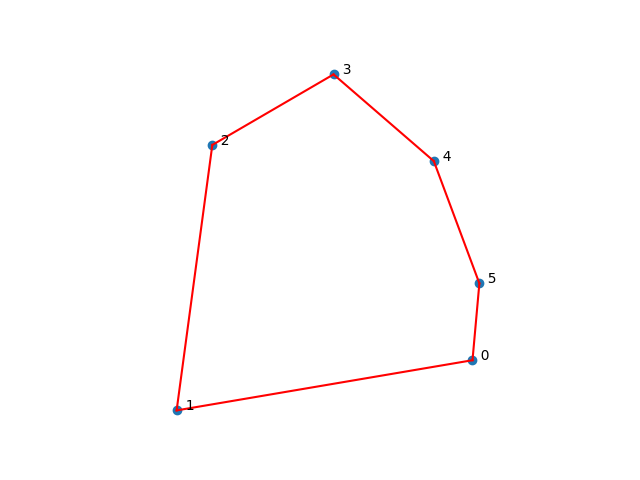

In [117]:
#We define a cyclic graph of order 6 with weights 1,2,3,4,5,6
G=Cyclic(6)
Weights=np.array([j+1 for j in range(6)])
Weights.shape=(6,1)
WV=np.hstack((G[1],Weights))
for wed in WV:
    print('The edge between vertex %d and vertex %d has weight %.3f'%(wed[0], wed[1],wed[2]))
S=Spettro((G[0], WV))
plot_plane=emb2d(G, S[2], S[3], nomi=True)
plot_plane.axis('off')
plot_plane.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


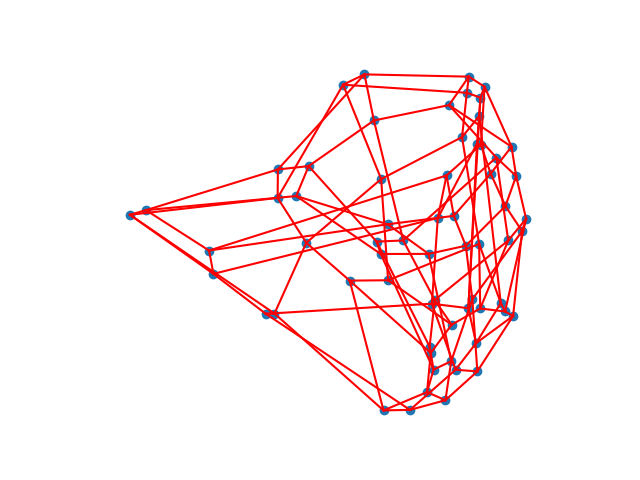

<IPython.core.display.Javascript object>


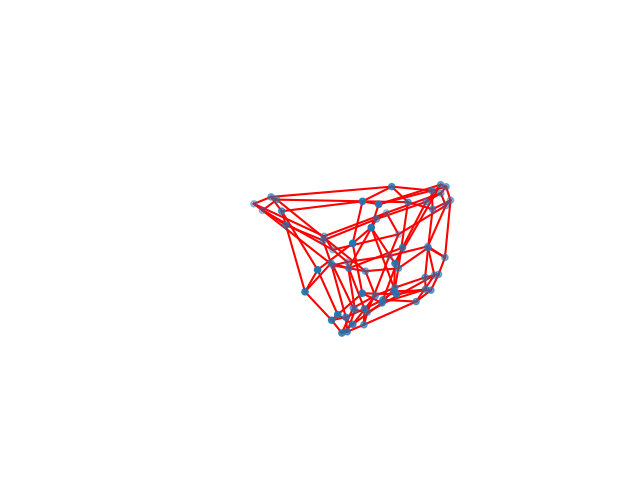

In [118]:
#We put random gaussian weights on the edges of a torus graph
G=Toro(8)
ne=len(G[1])
rand_g=np.random.normal(1,0.7,ne)
weights=np.array([abs(r) for r in rand_g]) #just in case they are negative...
weights.shape=(ne,1)
WV=np.hstack((G[1],weights))

S=Spettro((G[0], WV))
plot_plane=emb2d(G, S[2], S[3])
plot_plane.axis('off')
plot_plane.set_aspect('equal')
plt.show()
plot_space=emb3d(G, S[2], S[3])
foo=plot_space.axis('off')
plt.show()